In [1]:
#imports and read data from the corpus
import re
from collections import Counter
import numpy as np
import random
import nltk

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('bigp.txt', encoding = 'utf-8').read()))# read data and generate unique words and their freq
text = open('bigp.txt', encoding = 'utf-8').read()

w = list(WORDS.keys())
f = list(WORDS.values())

In [2]:
#Ngrams and their frequency distributions
nltk_tokens = nltk.word_tokenize(text)
bigrams = list(nltk.bigrams(nltk_tokens))   #Bigrams and their frequencies
fdistBi = nltk.FreqDist(bigrams)

trigrams = list(nltk.trigrams(nltk_tokens))  #Trigrams and their frequencies
fdistTri = nltk.FreqDist(trigrams)

fgrams = list(nltk.ngrams(nltk_tokens, 4))       #4-grams and their frequencies
fdistfg = Counter(fgrams)


In [3]:
#hyperparamters
TRESHps = 200 #frequency threshold for harvesting prefixed and suffixes
TRESHov = 8752*2   #20% of the original vocabulary is used to generate out of vocabulary words 
                #half through suffixes and half through prefixes
LAMBDA1 = 0.2; LAMBDA2 = 0.3; LAMBDA3 = 0.5;       #lambda parameter scores for linear interpolation
V = 87523    #vocabulary - unique list of words in corpus + dictionary
K = 0.0001          #value of K in add-K smoothing

# Building Model

In [87]:
nonWordHash = {}      #Training for non-word candidates hash

nonWordHash = WORDS
#nonWordHash['يونس']

nonWordHash = {k: v for k, v in sorted(nonWordHash.items(), key=lambda item: item[1], reverse = True)}  #non-word candidaes

prefix = {}
suffix = {}
for k, v in nonWordHash.items():                               #Identify most common prefixes and suffixes
    if len(k) > 4:
        if k[0] not in prefix.keys():
            prefix[k[:1]] = 1
        else:
            prefix[k[:1]] += 1
        
        if k[:2] not in prefix.keys():
            prefix[k[:2]] = 1
        else:
            prefix[k[:2]] += 1
            
#        if k[:3] not in prefix.keys():
#            prefix[k[:3]] = 1
#        else:
#            prefix[k[:3]] += 1
            
        if k[-1] not in suffix.keys():
            suffix[k[-1:]] = 1
        else:
            suffix[k[-1:]] += 1
        
        if k[-2:] not in suffix.keys():
            suffix[k[-2:]] = 1
        else:
            suffix[k[-2:]] += 1
        
#        if k[-3:] not in suffix.keys():
#            suffix[k[-3:]] += 1


for k in list(prefix.keys()):                     #filter prefixes and suffixes below threshold
    if prefix[k] < TRESHps:
        prefix.pop(k)
for k in list(suffix.keys()):
    if suffix[k] < TRESHps:
        suffix.pop(k)
len(prefix), len(suffix)

prefixKeys = list(prefix.keys())
suffixKeys = list(suffix.keys())
morphemes = []
#print(len(nonWordHash))
m = 0
for k in list(nonWordHash.keys()):                  #0.2 percent morphemes generated.
    m += 1
    if m > TRESHov:
        break
    p = random.randint(0, len(prefixKeys)-1)
    q = random.randint(0, len(suffixKeys)-1)
    morph1 = prefixKeys[p] + k
    morph2 = suffixKeys[q] + k
    #print(k, morph1, morph2)
    morphemes.append(morph1)
    morphemes.append(morph2)
#print(len(nonWordHash))    


#Filtering morphemes (newly generated words as candidates for non-word errors)
allWordsStr = ''.join(w)
charBi = list(nltk.bigrams(allWordsStr))            #generating bigrams and trigrams at the character level
charTri = list(nltk.trigrams(allWordsStr))
fdistCharBi = nltk.FreqDist(charBi)
fdistCharTri = nltk.FreqDist(charTri)

morscores = []
print('all morphemes:', len(morphemes))
for morph in morphemes:
    sc = 0
    for it in range(2, len(morph)):
        x1 = allWordsStr.count(morph[it])
        x2 = fdistCharBi[(morph[it-1], morph[it])]        
        x3 = fdistCharTri[(morph[it-2], morph[it-1], morph[it])]
        x1p = (allWordsStr.count(morph[it]) + K)/ (V + K*V)
        x2p = (x2+K) / (K*V + x1)
        x3p = (x3+K) / (K*V + x2)
        sc += LAMBDA1 * x1p + LAMBDA2 * x2p + LAMBDA3 * x3p 
    sc = sc / (len(morph) - 2.0 + K*V)
    morscores.append(sc)

for i in range(0, len(morphemes)):  #17504 newly added
    if morscores[i] > 1:
        nonWordHash[morphemes[i]] = (x1 + x2 + x3) / 3.0 #Morphemes that have passed their linear interpolation threshold
len(nonWordHash)

all morphemes: 35008


87253

In [90]:
morphemes[:1000]

['يد',
 'اد',
 'مـ',
 'کےـ',
 'دوپه',
 'تهپه',
 'برچې',
 'ګيچې',
 'کاکول',
 'ےکول',
 'كکښې',
 'رهکښې',
 'څاو',
 'واو',
 'څيا',
 'تيا',
 'کنکېدل',
 'ورکېدل',
 'خاو',
 'ړهو',
 'راهغه',
 'يتهغه',
 'اييو',
 'لييو',
 'سنه',
 'لونه',
 'غوي',
 'يوي',
 'تشي',
 'زشي',
 'ګوته',
 'وته',
 'سپسره',
 'ےسره',
 'چدے',
 'مهدے',
 'مبې',
 'ګبې',
 'چئې',
 'نيئې',
 'ورنۀ',
 'النۀ',
 'خرڅۀ',
 'ټڅۀ',
 'راشوے',
 'ړهشوے',
 'لاده',
 'ونده',
 'راكول',
 'اتكول',
 'چکار',
 'تهکار',
 'والکه',
 'نګلکه',
 'پېځاے',
 'دےځاے',
 'خچا',
 'انچا',
 'شوڅيز',
 'ديڅيز',
 'نډېر',
 'ګيډېر',
 'شووغېره',
 'زيوغېره',
 'فهم',
 'تهم',
 'صشان',
 'رهشان',
 'وركښې',
 'زهكښې',
 'القسم',
 'کےقسم',
 'مسبل',
 'رېبل',
 'مرا',
 'اتا',
 'غدا',
 'نۍدا',
 'خوسر',
 'نيسر',
 'پدي',
 'لدي',
 'موکوونکے',
 'ياکوونکے',
 'رووخت',
 'رهوخت',
 'بنوم',
 'تهنوم',
 'شوله',
 'دهله',
 'بلخبره',
 'نخبره',
 'توځان',
 'نۍځان',
 'لكېدل',
 'لكېدل',
 'کندې',
 'دلدې',
 'څزړۀ',
 'نےزړۀ',
 'ګرخبرې',
 'ليخبرې',
 'قپرې',
 'ديپرې',
 'اويوه',
 'ئييوه',
 'عورکول',
 'روورکول

In [4]:
realWordHash = {}        #training for building real word candidates hash

realWordHash = fdistTri + fdistfg
realWordHash = {k: v for k, v in sorted(realWordHash.items(), key=lambda item: item[1], reverse = True)}#real word candidates

i = 0
honMorphemes = {}
keys = list(realWordHash.keys())
for k,v in realWordHash.items():
    if i == TRESHov*20: 
        break
    i += 1
    rnd1 = random.randint(0, len(keys)-1)
    rnd2 = random.randint(0, len(keys)-1)
    part1 = list(keys[rnd1])
    part2 = list(keys[rnd2])
    part1a = part1[:-1]
    part2b = part2[-1]
    #honMorphemes[part1 + part2] = (realWordHash[keys[rnd1]] + realWordHash[keys[rnd2]])/2.0
    partab = part1a + [part2b]
    fsc = (realWordHash[keys[rnd1]] + realWordHash[keys[rnd2]])/2.0
    if fsc > 1:
        honMorphemes[tuple(partab)] = fsc
realWordHash.update(honMorphemes)

In [5]:
len(honMorphemes), len(realWordHash)

(43245, 1927830)

# Model Training Completed 

# Generate Test Data

In [6]:
#out of vocabulary words from new articles 
article = "ښاغلي سټولټنبرګ وویل سرمشریزه پر هغو لارو چارو وغږېده چې له افغانستان د بهرنیو ځواکونو تر وتلو وروسته، د حامد کرزي نړیوال هوايي ډګر د عملیاتو پر دوام ځان ډاډه کړي د شمالي اتلانتیک تړون سازمان ناټو سرمنشي ینس سټولټنبرګ دوشنبه په بروکسل کې ټینګار وکړ چې د کابل هوایي ډګر امنیت نه یوازې افغانستان کې د ناټو ملکي ماموریت، بلکې له افغانستان سره د نړیوالې ټولنې د اړیکو لپاره هم مهم دی د ناټو مشرانو هوکړه کړې چې له افغانستان د ځواکونو تر وتلو وروسته هم د کابل حامد کرزي نړیوال هوايي ډګر د امنیت ساتنې بودجه ولري. دغه هوکړه پرون( د جون ۱۴) برسلز کې د ناټو سرمشریزې پای اعلامیه کې شوې او ترکیې هم منلې، چې د ناټو ځواکونو تروتلو وروسته به هم د دغه هوايي ډګر امنیت ساتي د  امریکا د فضايي ادارې جونو سپوږمکۍ د مشتري سیارې (ګانیمېډ) تر ټولو نژدې انځورونه استولي چې د شمسي نظام تر ټولو لویه سیاره ګڼل کېږي.دا انځورونه له کابو زر کیلومتره لیرې واټن اخیستل شوي دي.په څه باندې شلو کلونو کې دې فضايي بېړۍ د ګانیمېډ دا تر ټولو نژدې انځورونه اخیستي دي د کنفرانس یوه بل ویناوال او د افغانستان د حج او اوقافو وزیر محمد قاسم حلیمي وویل،افغانستان کې د حکومت او مخالفانو ترمنځ د سولې غږونو تر راپورته کېدا وروسته د اسلام سپېڅلي ښار مکه مکرمه کې د ننني کنفرانس اړتیا پیدا شوه saudi د عکس سرچینه، RTA د سعوودي عرب په مکه کې د افغانستان او پاکستان دیني عالمانو ترمنځ د افغان سولې په تړاو لومړنۍ ګډه غونډه د سولې له بهیره د ملاتړ او د ګډ کار هوکړه لیک سره پای ته ورسېده. دا یوه ورځنۍ غونډه نن پنجشنبه د (رابطه عالم الاسلامي) سازمان په نوښت او د سعودي عرب په کوربتوب جوړه شوي وه. د مسلمانانو تر ټولو سپڅلي ځای ته نږدې په دې غونډه کې د افغانستان او پاکستان او دیني عالمانو او چارواکو ګډون درلود. د دې ناستې یو ګډونوال او د افغانستان د علماو د شورا مشر سردار ځدراڼ بي بي سي ته وویل، په ګډه اعلامیه کې په افغانستان او سیمه کې پر امن او سلامتیا ټینګار شوی. "
artWords = article.split(' ')

OVWords = []
for aw in artWords:             #out of vocabulary unigrams
    if aw not in WORDS.keys():
        OVWords.append(aw)
len(OVWords)

OVtri = list(nltk.trigrams(artWords))        #out of vocabulary trigrams
len(OVWords), len(OVtri)
del OVWords[40]
len(OVWords)

103

In [7]:
def randomizeWord(word):
    newStr = ''
    op = random.randint(1, 4)
    if op == 1: #insertion
        loc = random.randint(0,len(word)-1)
        nch = random.choice(allchar)
        newStr = str(word[0:loc]) + nch + str(word[loc: len(word)])
#        print('insertion', word, newStr)
        
    if op == 2: #deletion
        loc = random.randint(0, len(word)-1)
        newStr = str(word[0:loc]) + str(word[loc+1:len(word)])
#        print('deletion', word, newStr)
        
    if op == 3: #substitution
        loc = random.randint(0, len(word)-1)
        nch = random.choice(allchar)
        newStr = str(word[0:loc]) + nch + str(word[loc+1:len(word)])
#        print('substitution', word, newStr)
        
    if op == 4: #transposition
        loc = random.randint(0, len(word)-1)
        loc2 = random.randint(0, len(word)-1)
        tmp = word[loc]
        word.replace(word[loc], word[loc2])
        word.replace(word[loc2], tmp)
        newStr = word
#        print('transposition', word, newStr)
        
    if(newStr in nonWordHash.keys()):
        randomizeWord(word)
    else:
        return newStr

In [ ]:
#generate 400 non-word test data
allchar = 'ﺍ ﺏ پ ﺕ ټ ﺙ ﺝ چ ﺡ ﺥ څ ځ ﺩ ډ ﺫ ﺭ ړ ﺯ ژ ږ ﺱ ﺵ ښ ﺹ ﺽ ﻁ ﻅ ﻉ ﻍ ﻑ ﻕ ک ګ ﻝ ﻡ ﻥ ڼ ﻭ ه ۀ ي ې ی ۍ ئ'.replace(' ', '')
print('all char', allchar)
nonWordTestIDs = np.random.randint(low=0, high=len(w)-1, size=1000)         #sample 400 words from the corpus

#Keep the first 200 as correct non-word samples
nonWordTestData = []        
for it in range(0, 150):                           #first 150 are easy correct - in vocabulary correct words 
    word = w[nonWordTestIDs[it]]
    wl = [1, 'easy', word, str(word), WORDS[word]]
    nonWordTestData.append(wl)
    
for it in range(0, 50):                            #next 100 are hard correct - out of vocabulary correct words
    nonWordTestData.append([1, 'hard', OVWords[it], OVWords[it] ,0])

#Generate words with non-word spelling errors from the available data

for it in range(150, 1000):
    word = w[nonWordTestIDs[it]]
    wrong = ''
    wrong = randomizeWord(word)
    if wrong is not None:
        nonWordTestData.append([0, 'easy', wrong, word, WORDS[word]])
    if len(nonWordTestData) == 350:
        break

for it in range(0, 100):
    wrong = ''
    wrong = randomizeWord(OVWords[it])
    if wrong is not None:
        nonWordTestData.append([0, 'hard', wrong, OVWords[it], 0])
    if len(nonWordTestData) == 400:
        break
len(nonWordTestData)

In [ ]:
for i in range(200:400):
    if nonWordTest[i][2] == nonWordTest[i][]

In [8]:
#generate 400 real word test data
nonWordTestIDs = np.random.randint(low=0, high=len(w)-1, size=500)
sampleUnigrams = [w[i] for i in nonWordTestIDs]
sampleTrigrams = [trigrams[i] for i in nonWordTestIDs]
realWordTestData = []

for it in range(0, 150):                                 #150 from corpus correct real words 
    realWordTestData.append([1, 'easy', sampleTrigrams[it], sampleTrigrams[it], fdistTri[sampleTrigrams[it]]])
for it in range(0, 50):                                  #50 out of vocabulary correct real words
    realWordTestData.append([1, 'hard', OVtri[it], OVtri[it], 0])

for it in range(150, 350):                               #150 easy incorrect real word samples 
    wrong = list(sampleTrigrams[it][:2])
    wrong.append(sampleUnigrams[it])
    wrong = tuple(wrong)
    realWordTestData.append([0, 'easy', wrong, sampleTrigrams[it], fdistTri[sampleTrigrams[it]]])
#for it in range(50, 100):
#    wrong = list(OVtri[it][:2])
#    wrong.append(sampleUnigrams[150+it])
#    wrong = tuple(wrong)
#    realWordTestData.append([0, 'hard', wrong, OVtri[it], fdistTri[OVtri[it]]])

len(realWordTestData)


400

# Spell Check Analyzer

In [9]:
def P(word, N=sum(realWordHash.values())): 
    "Probability of `word`."
    return nonWordHash[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return sorted(candidates(word), reverse=True) #max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'ﺍﺏپﺕټﺙﺝچﺡﺥڅځﺩډﺫﺭړﺯژږﺱﺵښﺹﺽﻁﻅﻉﻍﻑﻕکګﻝﻡﻥڼﻭهۀيېیۍئ'                  #'abcdefghijklmnopqrstuvwxyz'
    letters    = str(set(''.join(w)))
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [ ]:
#Detection baseline
count = 0
for nwtest in nonWordTestData:
    if nwtest[2] in w:
        if nwtest[0] == 1:
            count += 1
    if nwtest[2] not in w:
        if nwtest[0] == 0:
            count += 1
count

In [ ]:
len(w), len(nonWordHash)

In [ ]:
#Non-word Detection /400
nwDetectYes = []
nwDetectNo = []
for nwtest in nonWordTestData:
    if nwtest[2] in nonWordHash.keys():
        if nwtest[0] == 1:
            nwDetectYes.append(nwtest)
        else:
            #print(nwtest)
            nwDetectNo.append(nwtest)
    else:
        if nwtest[0] == 1:
            nwDetectNo.append(nwtest)
        else:
            nwDetectYes.append(nwtest)
len(nwDetectYes)         #detection accurcy of 74.75%
len(nwDetectYes), len([nwc for nwc in nwDetectYes if nwc[1]== 'easy']), 

In [ ]:
len([i for i in nonWordTestData if i[4] >= 20 and i[0] == 0])

In [ ]:
[nwc for nwc in nwDetectYes if nwc[4] >= 2 and nwc[4] < 5]

In [ ]:
#Non-word error correction /200
nwCorrectYes = []
nwCorrectNo = []
for it in range(0, 200):
    ww = nonWordTestData[it][2]
    cor = list(candidates(ww))
    if len(cor) > 10:
        cor = cor[:10]
    if nonWordTestData[it][3] in cor:
        nwCorrectYes.append(nonWordTestData[it])
    else:
        nwCorrectNo.append(nonWordTestData[it])
len(nwCorrectYes)

In [ ]:
len([nwc for nwc in nonWordTestData[:200] if nwc[4] >= 20 and nwc[0] == 1]), len([nwc for nwc in nwCorrectNo if nwc[4] >= 20 and nwc[0] == 1])


In [ ]:
len(nwCorrectNo), len(nwCorrectYes)

In [ ]:
nwCorrectNo

In [10]:
def lis(wordTrigram):
    x1 = WORDS[wordTrigram[0]]
    x2 = fdistBi[tuple(wordTrigram[:2])]
    x3 = fdistTri[tuple(wordTrigram[:3])]
    x1p = (x1 + K) / (V + K*V)
    x2p = (x2 + K) / (x1 + K*V)
    x3p = (x3 + K) / (x2 + K*V)
    return LAMBDA1* x1p + LAMBDA2 * x2p + LAMBDA3 * x3p

In [86]:
#real word error detection
rwDetectYes = []
rwDetectNo = []
for tcase in realWordTestData:
    #sc = linearInterpolation(tcase[2])
    if (tcase[2] in realWordHash and realWordHash[tcase[2]] > 1):
        rwDetectYes.append(tcase)
    else:
        rwDetectNo.append(tcase)

In [79]:
len(rwDetectYes)

292

In [80]:
len([i for i in realWordTestData if i[4] == 0]), len([rw for rw in rwDetectYes if rw[0] == 1 and rw[4] == 0]), len([rw for rw in rwDetectNo if rw[0] == 0 and rw[4] == 0])

(50, 10, 0)

In [81]:
len([i for i in realWordTestData if i[4] == 1]), len([rw for rw in rwDetectYes if rw[0] == 1 and rw[4] == 1]), len([rw for rw in rwDetectNo if rw[0] == 0 and rw[4] == 1])

(255, 108, 62)

In [82]:
len([i for i in realWordTestData if i[4] >= 2 and i[4] < 5]), len([rw for rw in rwDetectYes if rw[0] == 1 and rw[4] >= 2 and rw[4] < 5]), len([rw for rw in rwDetectNo if rw[0] == 0 and rw[4] >= 2 and rw[4] < 5])

(63, 30, 4)

In [83]:
len([i for i in realWordTestData if i[4] >= 5 and i[4] < 10]), len([rw for rw in rwDetectYes if rw[0] == 1 and rw[4] >= 5 and rw[4] < 10]), len([rw for rw in rwDetectNo if rw[0] == 0 and rw[4] >= 5 and rw[4] < 10])

(10, 4, 1)

In [84]:
len([i for i in realWordTestData if i[4] >= 10 and i[4] < 20]), len([rw for rw in rwDetectYes if rw[0] == 1 and rw[4] >= 10 and rw[4] < 20]), len([rw for rw in rwDetectNo if rw[0] == 0 and rw[4] >= 10 and rw[4] < 20])

(7, 3, 0)

In [85]:
len([i for i in realWordTestData if i[4] >= 20]), len([rw for rw in rwDetectYes if rw[0] == 1 and rw[4] >= 20]), len([rw for rw in rwDetectNo if rw[0] == 0 and rw[4] >= 20])

(15, 5, 1)

In [61]:
realWordTestData

[[1, 'easy', ('درسره', 'کلک', 'ولاړ'), ('درسره', 'کلک', 'ولاړ'), 1],
 [1, 'easy', ('په', 'اصل', 'کښې'), ('په', 'اصل', 'کښې'), 30],
 [1, 'easy', ('چې', 'د', 'يوې'), ('چې', 'د', 'يوې'), 25],
 [1, 'easy', ('وريادول', '(', 'و'), ('وريادول', '(', 'و'), 2],
 [1, 'easy', ('بې', 'آرامي', '،'), ('بې', 'آرامي', '،'), 1],
 [1, 'easy', ('چرګوړے', '،', 'د'), ('چرګوړے', '،', 'د'), 2],
 [1, 'easy', ('نبوت', 'چلېږي', 'او'), ('نبوت', 'چلېږي', 'او'), 1],
 [1, 'easy', ('مجلو', 'كښې', 'يو'), ('مجلو', 'كښې', 'يو'), 1],
 [1, 'easy', ('بيان', 'کړي', 'دي'), ('بيان', 'کړي', 'دي'), 5],
 [1, 'easy', ('ئې', 'دفارسي', 'قصيدو'), ('ئې', 'دفارسي', 'قصيدو'), 1],
 [1, 'easy', ('کټ', 'بستره', 'اس'), ('کټ', 'بستره', 'اس'), 1],
 [1, 'easy', ('’', 'په', 'دې'), ('’', 'په', 'دې'), 7],
 [1,
  'easy',
  ('کېدونکے', '،', 'ابادېدونکے'),
  ('کېدونکے', '،', 'ابادېدونکے'),
  1],
 [1, 'easy', ('ـ', 'عاصي', 'هشنغري'), ('ـ', 'عاصي', 'هشنغري'), 1],
 [1, 'easy', ('ته', 'رسېدل', '،'), ('ته', 'رسېدل', '،'), 6],
 [1, 'easy', ('زير', '’', '

In [99]:
#real word correction
rwCorrectYes = []
rwCorrectNo = []
for tcase in realWordTestData[200:400]:
    if tcase[2] in realWordHash or lis(tcase[2]) > 0.01:
        rwCorrectYes.append(tcase)
    else:
        rwCorrectNo.append(tcase)

In [109]:
len([i for i in rwCorrectYes if i[4] >=20]), len([i for i in rwCorrectNo if i[4] >= 20])

(10, 0)

In [93]:
len([i for i in realWordTestData if i[4] == 0]), len([i for i in rwCorrectNo if i[4] == 0])

(50, 0)

# real word error detection

𝑝 ̂(𝑤_𝑛│𝑤_(𝑛−1),𝑤_(𝑛−2) )=𝜆_1 𝑝(𝑤_𝑛│𝑤_(𝑛−1),𝑤_(𝑛−2) )
+𝜆_2 𝑝(𝑤_𝑛│𝑤_(𝑛−1) )
〖+𝜆〗_3 𝑝(𝑤_𝑛)
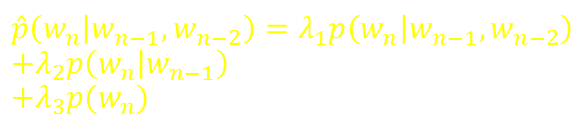

In [ ]:
lambda1 = 0.25; lambda2 = 0.35; lambda3 = 0.4;
scores = []
ewf = []
bifreq = nltk.FreqDist(bigrams)
trifreq = nltk.FreqDist(trigrams)
for i in range(0, len(testTrigrams)):
    uni = testUnigrams[i]
    bi = testTrigrams[i][:1]
    tri = testTrigrams[i][:2]
    unif = WORDS[uni]
    unifp = unif/87253.0 
    
    tmp = list(bi)
    tmp.append(uni)
    tmp = tuple(tmp)
    bif = bifreq[tmp]
    bifp = (bif + 1)/(WORDS[tmp[0]]+87253.0)

    tmp2 = list(tri)
    tmp2.append(uni)
    tmp2 = tuple(tmp2)
    trif = (trifreq[tmp2]+1)/(bifreq[tmp2[1:]]+87253.0)
    print(trif)
    scores.append(lambda1*unif + lambda2*bif + lambda3*trif)
    ewf.append(unif)

In [ ]:
scores

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(scores)
plt.ylabel('some numbers')
plt.show()

In [ ]:
len([i for i in scores if i > 0.5]), len([i for i in scores if i > 1]), len([i for i in scores if i > 2]), len([i for i in scores if i > 3]), len([i for i in scores if i > 4]), len([i for i in scores if i > 5]), len([i for i in scores if i > 6]), len([i for i in scores if i > 7]), len([i for i in scores if i > 8]), len([i for i in scores if i > 9]), len([i for i in scores if i > 10])

In [ ]:
len([i for i in scores if i > 11]), len([i for i in scores if i > 12]), len([i for i in scores if i > 13]), len([i for i in scores if i > 14]), len([i for i in scores if i > 15]), len([i for i in scores if i > 16]), len([i for i in scores if i > 17]), len([i for i in scores if i > 18]), len([i for i in scores if i > 19]), len([i for i in scores if i > 20])

In [ ]:
len([i for i in scores if i > 21]), len([i for i in scores if i > 22]), len([i for i in scores if i > 23]), len([i for i in scores if i > 24]), len([i for i in scores if i > 25]), len([i for i in scores if i > 26]), len([i for i in scores if i > 27]), len([i for i in scores if i > 28]), len([i for i in scores if i > 29]), len([i for i in scores if i > 30])

# Real word error correction

In [ ]:
lambda1 = 0.25; lambda2 = 0.35; lambda3 = 0.4;
scores2 = []
bifreq = nltk.FreqDist(bigrams)
trifreq = nltk.FreqDist(trigrams)
for i in range(0, len(testTrigrams)):
    uni = testTrigrams[i][:1]
    bi = testTrigrams[i][:2]
    tri = testTrigrams[i][:3]
    
    unif = WORDS[uni]
    unifp = (unif + 1)/ (87253.0)
    bif = bifreq[bi]
    bifp = (bif + 1) / (WORDS[bi[0]] + 87253.0)
    trif = trifreq[tri]
    trifp = (trif + 1) / (bifreq[tri[1:]] + 87253.0)
    scores2.append(lambda1*unif + lambda2*bif + lambda3*trif)
    

In [ ]:
scores2

In [ ]:
nscores = [s/400.0 for s in scores]
nscores2 = [s/2800.0 for s in scores2]
items = [i for i in range(1, 1001)]

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,4)
plt.bar(items, nscores)
plt.bar(items, nscores2)
plt.ylabel('some numbers')
plt.show()

In [ ]:
len([i for i in scores2 if i > 0.5]), len([i for i in scores2 if i > 1]), len([i for i in scores2 if i > 2]), len([i for i in scores2 if i > 3]), len([i for i in scores2 if i > 4]), len([i for i in scores2 if i > 5]), len([i for i in scores2 if i > 6]), len([i for i in scores2 if i > 7]), len([i for i in scores2 if i > 8]), len([i for i in scores2 if i > 9]), len([i for i in scores2 if i > 10])

In [ ]:
len([i for i in scores2 if i > 11]), len([i for i in scores2 if i > 12]), len([i for i in scores2 if i > 13]), len([i for i in scores2 if i > 14]), len([i for i in scores2 if i > 15]), len([i for i in scores2 if i > 16]), len([i for i in scores2 if i > 17]), len([i for i in scores2 if i > 18]), len([i for i in scores2 if i > 19]), len([i for i in scores2 if i > 20])

In [ ]:
len([i for i in scores2 if i > 21]), len([i for i in scores2 if i > 22]), len([i for i in scores2 if i > 23]), len([i for i in scores2 if i > 24]), len([i for i in scores2 if i > 25]), len([i for i in scores2 if i > 26]), len([i for i in scores2 if i > 27]), len([i for i in scores2 if i > 28]), len([i for i in scores2 if i > 29]), len([i for i in scores2 if i > 30])

# Appendix

In [93]:
len(w)
ct = cf = ce = cw = 0
for i in range(len(w)):         #Unigram counts at different frequencies
    if f[i] >= 2 and f[i] < 5:
        ct += 1
    if f[i] >= 5 and f[i] < 10:
        cf += 1
    if f[i] >= 10:
        ce += 1
    if f[i] == 1:
        cw += 1

print('2: ', ct)
print('5: ', cf)
print('10: ', ce)
print('20: ', cw)
#total unigrams 87253
#total unigrams f>2: 25994
#total unigrams f>5: 14000
#total unigrams f>10: 8451
#total unigrams f>20: 4905

2:  23553
5:  7167
10:  9171
20:  47362


In [95]:



ct = cf = ce = cw = 0
for k,v in fdistBi.items():
    if v == 1:
        ct += 1
    if v >= 2 and v < 5:
        cf += 1
    if v >= 5 and v < 10:
        ce += 1
    if v >= 10:
        cw += 1
print('2: ', ct)
print('5: ', cf)
print('10: ', ce)
print('20: ', cw)

#total bigrams 1104314
#total bigrams f>2: 51176
#total bigrams f>5: 18326
#total bigrams f>10: 8044
#total bigrams f>20: 3497

2:  436362
5:  80034
10:  14573
20:  9104


In [97]:
ct = cf = ce = cw = 0
for k,v in fdistTri.items():         #Trigram counts at different frequencies
    if v == 1:
        ct += 1
    if v >= 2 and v < 5:
        cf += 1
    if v >= 5 and v < 10:
        ce += 1
    if v >= 10:
        cw += 1
print(len(trigrams))
print('2: ', ct)
print('5: ', cf)
print('10: ', ce)
print('20: ', cw)

#total trigrams 1104313
#total trigrams f>2: 29904
#total trigrams f>5: 18346
#total trigrams f>10: 3260
#total trigrams f>20: 1256

1104298
2:  791115
5:  67248
10:  7583
20:  3785


In [99]:
v = list(fdistfg.keys())
f = list(fdistfg.values())
ct = cf = ce = cw = 0
for i in range(len(f)):         #4-gram scores at different frequencies
    if f[i] == 1:
        ct += 1
    if f[i] >= 2 and f[i] < 5:
        cf += 1
    if f[i] >= 5 and f[i] < 10:
        ce += 1
    if f[i] >= 10:
        cw += 1

#print(len(f))
print('2: ', ct)
print('5: ', cf)
print('10: ', ce)
print('20: ', cw)

#4grams: 1016696
#4grams f > 2: 12085
#4grams f > 5: 2656
#4grams f > 10: 903
#4grams f > 20: 330

2:  974216
5:  38650
10:  2762
20:  1057


In [ ]:
def unit_tests():
    assert correction('مجر') == 'مېجر'              # insert
    assert correction('يوس') == 'يونس'           # replace 2
    return 'unit_tests pass'

def spelltest(tests, verbose=False):
    "Run correction(wrong) on all (right, wrong) pairs; report results."
    import time
    start = time.clock()
    good, unknown = 0, 0
    n = len(tests)
    for right, wrong in tests:
        w = correction(wrong)
        good += (w == right)
        if w != right:
            unknown += (right not in WORDS)
            if verbose:
                print('correction({}) => {} ({}); expected {} ({})'
                      .format(wrong, w, WORDS[w], right, WORDS[right]))
    dt = time.clock() - start
    print('{:.0%} of {} correct ({:.0%} unknown) at {:.0f} words per second '
          .format(good / n, n, unknown / n, n / dt))
    
def Testset(lines):
    "Parse 'right: wrong1 wrong2' lines into [('right', 'wrong1'), ('right', 'wrong2')] pairs."
    return [(right, wrong)
            for (right, wrongs) in (line.split(':') for line in lines)
            for wrong in wrongs.split()]

if __name__ == '__main__':
    print(unit_tests())
    spelltest(Testset(open('spell-testset1.txt')))
    spelltest(Testset(open('spell-testset2.txt')))
